## Investigate

- how does MAD look across years/seasons?
- same for SD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import xarray as xr

import fields
import cov_model
import plot

%matplotlib inline

In [4]:
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

var_names = ["xco2", "sif"]
cross_name = "xco2:sif"


In [73]:
# Analysis variables
month = 8
timedelta = -2
n_bins = 60
fast_dist = True

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")
timestamp = timestamps[0]
print(f"Timestamp: {timestamp}")

# param_guess = [sigma1, nu1, ell1, tau1, nu12, ell12, rho12, sigma2, nu2, ell2, tau2]
params_guess = [1.0, 1.5, 700, 0.0, 1.5, 700, -0.8, 1.0, 1.5, 700, 0.0]


Timestamp: 2015-08-01


In [74]:
# Initialize Matern model
k1 = cov_model.Matern()
k2 = cov_model.Matern()


In [75]:
mf = fields.MultiField(
    ds_xco2, ds_sif, timestamp, timedelta=timedelta, fast_dist=fast_dist
)
model = cov_model.BivariateMatern(mf, k1, k2)
vario_res, covario_res, params_fit = model.empirical_variograms(
    params_guess, n_bins=n_bins
)


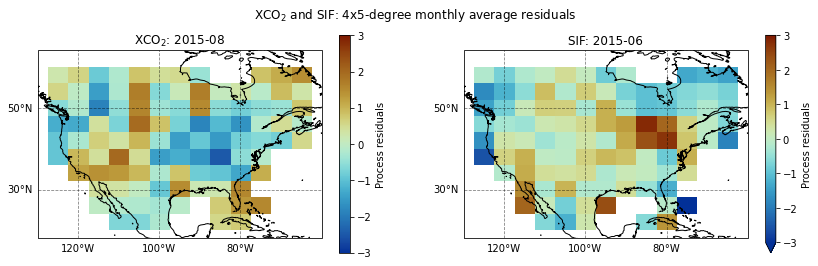

In [76]:
plot.plot_fields(mf)

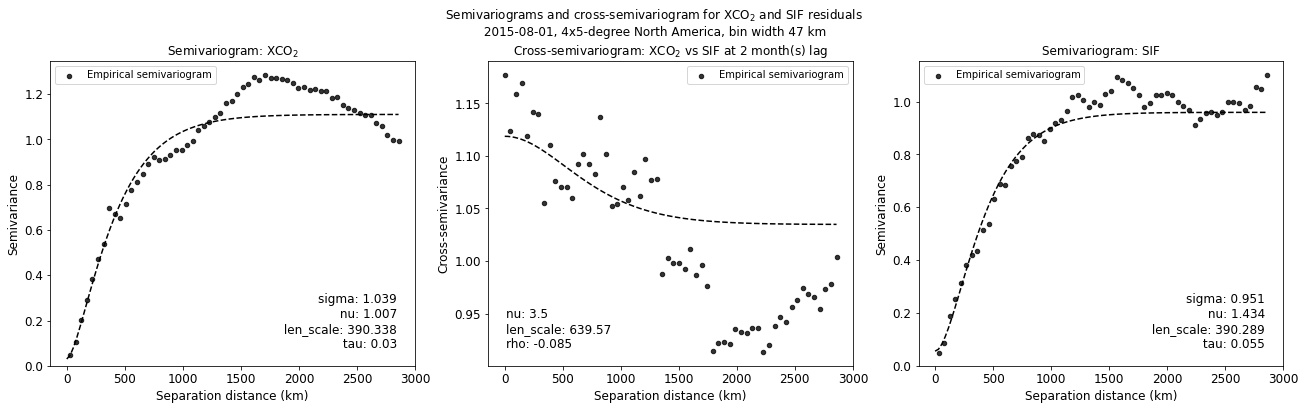

In [77]:
fname = f"semivariograms_conus4x5_{timestamp}_{np.abs(timedelta)}Mlag"
# plot.plot_semivariograms(vario_res, timestamp, timedelta, params=params_fit, filename=fname)
plot.plot_variograms(vario_res, timestamp, timedelta, params=params_fit)


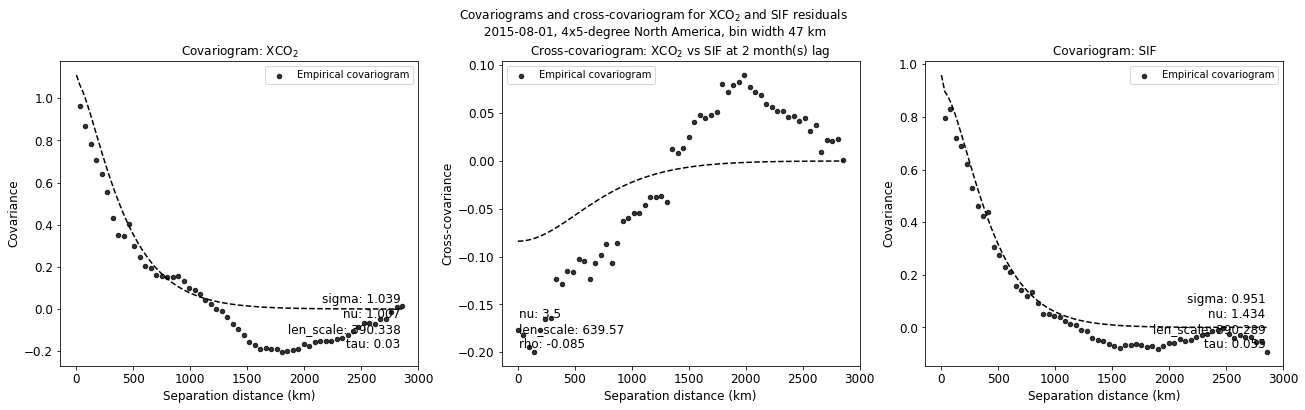

In [78]:
plot.plot_variograms(
    covario_res,
    timestamp,
    timedelta,
    params=params_fit,
    type_lab="Covariogram",
    scale_lab="Covariance",
)
